### 사용목적 : 처방 관리 앱

* 코로나19로 인해 비대면 의료가 허용되면서 환자들도 자신의 처방을 데이터베이스화 할 수 있는 환경이 마련되고 있다.
* 이것이 앞으로 대면 의료로 다시 전환되면 끊어질 것을 대비하여, 환자가 자신의 처방전이나 약 봉지를 스캔하면 자동으로 자신이 먹는 약에 대한 정보(충돌 약 정보, 제네릭 정보 등)와 투약 관리를 받을 수 있는 앱을 제작하면 좋을 것이라 생각한다.
* 이러한 목적에 비추어, OCR 모델은 무엇보다 '인쇄된 정보를 빼놓지 않고 정확하게 인식하는 것'이 필요할 것이다.

## 1. 검증용 데이터 준비 

* 처방전 4개와 약봉지 4개의 데이터셋

In [1]:
import os
 
img = os.getenv('HOME')+'/aiffel/ocr_python/images'
img_list = os.listdir(img)
img_list

['2.jpg', '7.jpg', '6.jpg', '5.jpg', '3.jpg', '4.jpg', '8.jpg', '1.jpg']

## 2. keras-ocr

In [2]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [3]:
images = [keras_ocr.tools.read(os.path.join(img, file)) for file in img_list]
prediction_groups = [pipeline.recognize([os.path.join(img, file)]) for file in img_list]

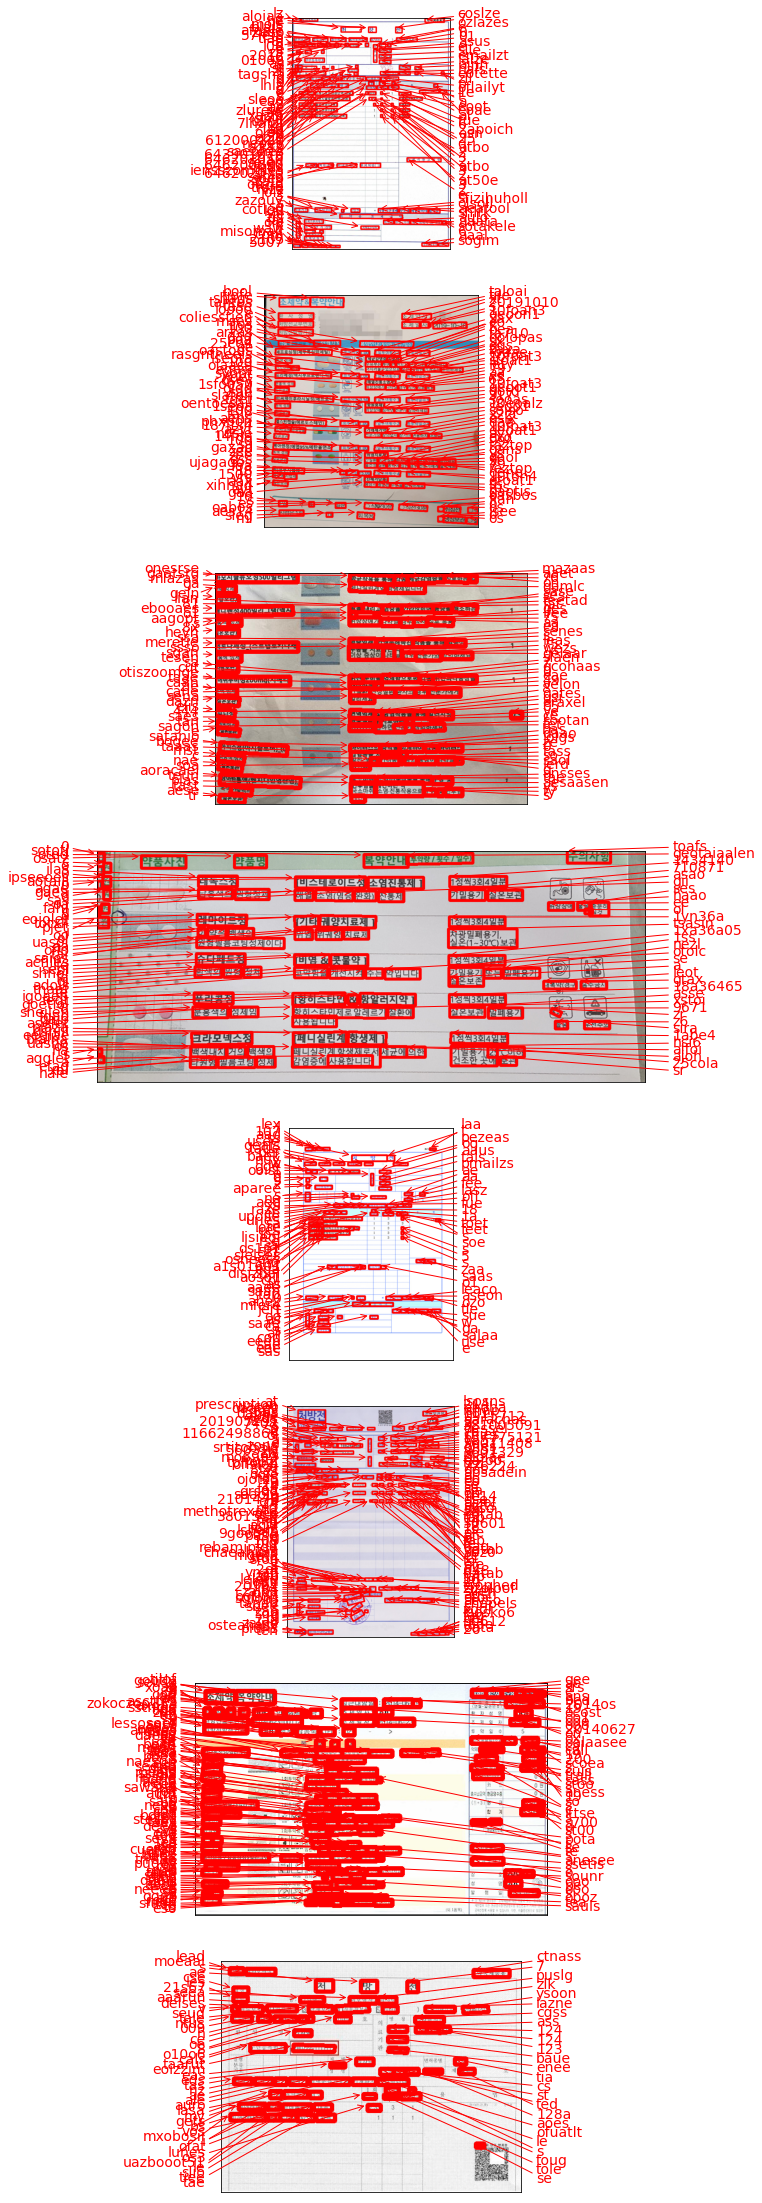

In [4]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 40))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## 3. Tesseract

In [9]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    
    image = Image.open(image_path)
#     image = image.resize((180,180)) # 크기 조정

    recognized_data = pytesseract.image_to_data(
        image, lang='eng+kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor+eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text']) 
    print("Done")


work_dir = os.getenv('HOME')+'/aiffel/ocr_python/images'

for i in range(1,9):
    try:
        img_file_path = work_dir + '/'+str(i)+'.jpg'
        print(f'[{i}]')
        print('--------------------------------------------------------------')
        cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
        recognize_images(cropped_image_path_list)
    except AttributeError:
        print(f"{i} 에러 발생")
    except SystemError:
        print()

[1]
--------------------------------------------------------------
/aiffel/aiffel/ocr_python/images/0000.png
/aiffel/aiffel/ocr_python/images/0001.png
/aiffel/aiffel/ocr_python/images/0002.png
/aiffel/aiffel/ocr_python/images/0003.png
/aiffel/aiffel/ocr_python/images/0004.png
/aiffel/aiffel/ocr_python/images/0005.png
/aiffel/aiffel/ocr_python/images/0006.png
/aiffel/aiffel/ocr_python/images/0007.png
/aiffel/aiffel/ocr_python/images/0008.png
/aiffel/aiffel/ocr_python/images/0009.png
/aiffel/aiffel/ocr_python/images/0010.png
/aiffel/aiffel/ocr_python/images/0011.png
/aiffel/aiffel/ocr_python/images/0012.png
/aiffel/aiffel/ocr_python/images/0013.png
/aiffel/aiffel/ocr_python/images/0014.png
/aiffel/aiffel/ocr_python/images/0015.png
/aiffel/aiffel/ocr_python/images/0016.png
/aiffel/aiffel/ocr_python/images/0017.png
/aiffel/aiffel/ocr_python/images/0018.png
/aiffel/aiffel/ocr_python/images/0019.png
/aiffel/aiffel/ocr_python/images/0020.png
/aiffel/aiffel/ocr_python/images/0021.png
/aiffel/a

## 회고

* keras ocr은 인쇄 정보를 모두 포착했지만 한글 데이터셋으로 훈련이 되어있지 않아 recognition이 이상하다.
* Tesseract는 한글은 된다는데 detection부터 문제다. 이것이 괜찮게 됐다면 사용할 수 있었을텐데 아쉽다.
* 지금 당장 ocr을 써야한다면 Google OCR API 나 다른 모델을 알아봐야하겠다. 위의 두 가지는 쓸 수가 없다.
* 모델이 잘 갖추어져 있어야 데이터가 중요한 것임을 느꼈다.